100%|██████████| 155/155 [00:00<00:00, 237.55it/s]


Number of classes,  4


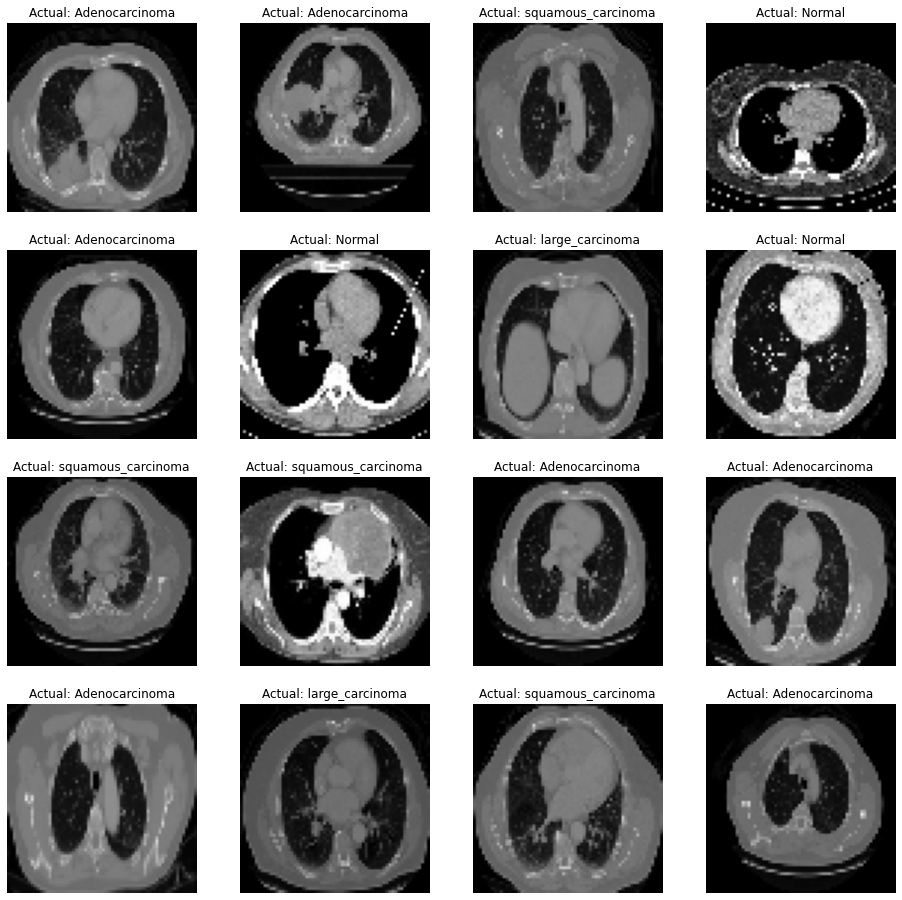

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Model
from tqdm import tqdm
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks

classes = {'Normal': 0, 'Adenocarcinoma': 1, 'large_carcinoma': 2, 'squamous_carcinoma': 3}

Normal_test=r'test/normal'
Adenocarcinoma_test=r'test/adenocarcinoma'
Large_carcinoma_test=r'test/large.cell.carcinoma'
Squamous_carcinoma_test=r'test/squamous.cell.carcinoma'

Normal_train=r'train/normal'
Adenocarcinoma_train=r'train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
Large_carcinoma_train=r'train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
Squamous_carcinoma_train=r'train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'


IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE=64
N_CLASSES = 4
EPOCHS = 100

def assign_label(img,class_type):
    return class_type

X = []
y = []

def make_train_data(class_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,class_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(str(label))

make_train_data(classes.get('Normal'), Normal_test)

make_train_data(classes.get('Normal'), Normal_train)

make_train_data(classes.get('Adenocarcinoma'), Adenocarcinoma_test)

make_train_data(classes.get('Adenocarcinoma'), Adenocarcinoma_train)

make_train_data(classes.get('large_carcinoma'), Large_carcinoma_test)

make_train_data(classes.get('large_carcinoma'), Large_carcinoma_train)

make_train_data(classes.get('squamous_carcinoma'), Squamous_carcinoma_test)

make_train_data(classes.get('squamous_carcinoma'), Squamous_carcinoma_train)


len(X)
y = np.array(y)
X = np.array(X)


from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=58954)


k = len(set(y_train))
print("Number of classes, ", k)

X_train = X_train.astype('float64')/255
X_test = X_test.astype('float64')/255

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

labels = '''Normal
Adenocarcinoma
large_carcinoma
squamous_carcinoma
'''.split("\n")

plt.figure(figsize=(16,16))
j = 1
for i in np.random.randint(0,252,16):
    plt.subplot(4,4,j); j+=1
    plt.imshow(X_train[i],cmap = 'Greys')
    plt.axis('off')
    plt.title("Actual: {}".format(labels[np.argmax(y_train[i])]))
    #plt.title('{} / {}'.format(labels[y_train[i]],y_train[i]))



In [3]:
i = layers.Input(shape = (X_train[0].shape))
x = layers.Conv2D(64, (3,3), activation="relu", strides=(2,2), padding="same" )(i)
x = layers.Conv2D(64, (3,3), activation="relu", strides=(2,2), padding="same" )(x)
x = layers.Conv2D(32, (3,3), activation="relu", strides=(2,2), padding="same" )(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(k, activation='softmax')(x)

#Construction du modèle:
model = Model(i, x)

model.summary()
#Compilation du modèle :
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=3, min_lr=0.00001)

model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=  (X_test,y_test), callbacks=[reduce_lr])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [9]:
from graphviz import *
from pydot import *
keras.utils.plot_model(model, "test.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


6/6 [==============================] - 0s 14ms/step
Confusion matrix, without normalization
[[39  0  0  0]
 [ 0 58  0  6]
 [ 0  3 34  1]
 [ 0  7  0 38]]


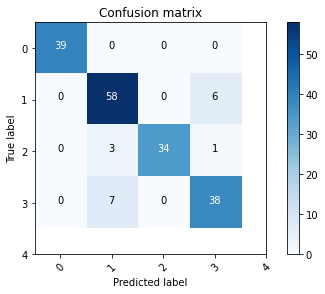

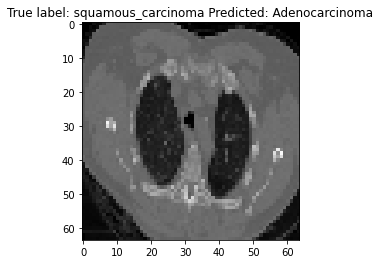

In [5]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#Etape de prédiction
p_test = model.predict(X_test).argmax(axis=1)
#Matrice de confusion
cm = confusion_matrix(np.argmax(y_test, axis= 1), p_test)
plot_confusion_matrix(cm, list(range(5)))

misclassified_idx = np.where(p_test != np.argmax(y_test, axis= 1))[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[np.argmax(y_test[i])], labels[p_test[i]]));